##Preamble
I just found out about the seaborn library. It makes super pretty plots, as you will see, and is a much-needed change from the MATLAB plot colors. 

In [1]:
import numpy as np, scipy.stats as ss, pandas as pd, statsmodels.api as sm
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import pandas.io.data as web
import seaborn as sns #import new pretty plot library
import datetime  

%matplotlib inline
#set plot palette and styles 
sns.set_palette('muted')
sns.set_context(rc={"figure.figsize": (8, 4)})
sns.set_style('dark')

##Download the data from Yahoo! Finance
I don't think there's an easy way to just download the Adj Close data at a business-month-start (BMS) frequency, so I just pulled the entire daily open-low-high-close dataset, downsampled to BMS, and took the "last" value as the price for that month.

In [2]:
#download all stock data
start = datetime.datetime(1998, 1, 1)
end = datetime.datetime(2009, 12, 31)

stocks = ['VBLTX','FMAGX','SBUX']

all_prices = web.DataReader(stocks, 'yahoo', start, end)

# take only adjusted close price, downsample to monthly, take last price
all_prices=all_prices.ix['Adj Close'].resample('BMS','last')
all_prices= all_prices[['VBLTX','FMAGX','SBUX']]

##Calculate the continuously compounded returns using
\begin{equation}
    r_t=\ln(1+R_t)=\ln(1+\frac{P_t - P_{t-1}}{P_{t-1}}) =  \ln(\frac{P_t}{P_{t-1}}) = \ln(P_t) - \ln(P_{t-1})
\end{equation}

In [3]:
#a nice one-liner
all_returns = np.log(all_prices).diff() 

##Plot the returns
First we'll do a simple line plot. Note the nice non-MATLAB-style plot.

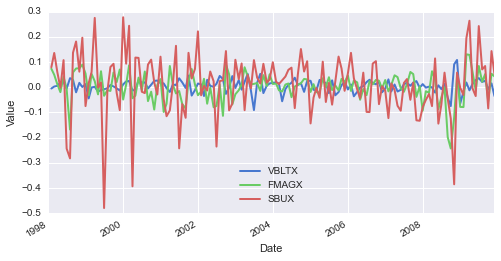

In [4]:
all_returns.plot(linewidth=2)
plt.ylabel('Value')

Since that line plot above is a little hard to read, let's plot the returns as bar plots.

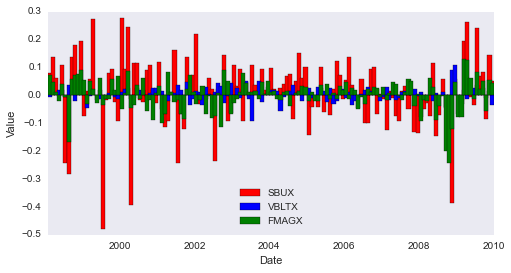

In [5]:
domain = all_returns.index
plt.bar(domain,all_returns.SBUX,width=40,color='r')
plt.bar(domain,all_returns.VBLTX,width=40,color='b')
plt.bar(domain,all_returns.FMAGX,width=40,color='g')
plt.legend(['SBUX','VBLTX','FMAGX'],loc='best')
plt.ylabel('Value')
plt.xlabel('Date')

Now let's see our return on a $1 investment. We can do this by plotting the cumulative product. 

\begin{equation}
R_{Gross} = 1+R_{t}= 1+ \left[exp\left(r_t\right) - 1 \right] = exp\left(r_t\right)
\end{equation}

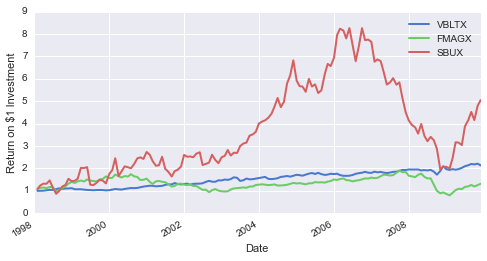

In [6]:
simple_returns = np.exp(all_returns)
simple_returns.cumprod().plot(linewidth=2)
plt.ylabel('Return on $1 Investment')

##Let's graphically analyze the univariate stats of VBLTX

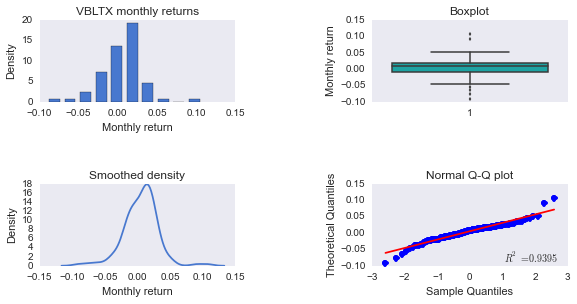

In [7]:
import scipy.stats as stats

f, axs = plt.subplots(2, 2)
f.tight_layout()
plt.subplots_adjust(hspace = 1,wspace=0.7)


VBLTX_values=all_returns['VBLTX'][1:].values
#compute density histogram
x=np.histogram(VBLTX_values,density=True)
hist_data = x[:][0]
bin_edges=x[:][1]
width = 0.7 * (bin_edges[1] - bin_edges[0])
center = (bin_edges[:-1] + bin_edges[1:]) / 2
axs[0,0].bar(center, hist_data, align='center', width=width)
axs[0,0].set_title('VBLTX monthly returns')
axs[0,0].set_xlabel('Monthly return')
axs[0,0].set_ylabel('Density')

#plot boxplot using Seaborn because it's prettier
sns.boxplot(VBLTX_values,color='c',ax=axs[0,1])
axs[0,1].set_title('Boxplot')
axs[0,1].set_ylabel('Monthly return')

#plot kernel density estimate
sns.kdeplot(VBLTX_values,ax=axs[1,0])
axs[1,0].set_title('Smoothed density')
axs[1,0].set_xlabel('Monthly return')
axs[1,0].set_ylabel('Density')

#alternatively...
# density=stats.gaussian_kde(VBLTX_values)
# xs = np.linspace(-.125,0.125,100)
# axs[1,0].plot(xs,density(xs))

#plot quantile-quantile 
res=stats.probplot(VBLTX_values, dist="norm",plot=axs[1,1])
axs[1,1].set_title('Normal Q-Q plot')
axs[1,1].set_xlabel('Sample Quantiles')
axs[1,1].set_ylabel('Theoretical Quantiles')

##Let's compare the return distributions of all 3 stocks
We can easily visualize this using pandas boxplot function. Clearly we see that SBUX has the greatest variance.

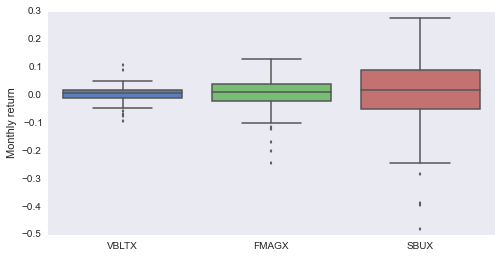

In [8]:
sns.boxplot(all_returns)
plt.ylabel('Monthly return')

##Compute univariate descriptive statistics
Compute skewness and kurtosis from scipy.stats, and append onto df.describe() statistics.

In [9]:
x=stats.describe(all_returns[1:],axis=0)

description2= pd.DataFrame({'skewness':x.skewness,'kurtosis':x.kurtosis},
                          index=['VBLTX','FMAGX','SBUX']).transpose()

description1=all_returns.describe()

description = pd.concat([description1,description2])
description

,VBLTX,FMAGX,SBUX
count,143.000000,143.000000,143.000000
mean,0.005294,0.001888,0.011318
std,0.026061,0.056620,0.119392
min,-0.090886,-0.243371,-0.479702
25%,-0.009523,-0.020451,-0.048829
50%,0.008622,0.009946,0.018155
75%,0.019672,0.039646,0.086756
max,0.107894,0.130240,0.277320
kurtosis,2.962559,2.704500,2.694763
skewness,-0.150674,-1.043597,-0.906070


##Compute annualized monthly estimates
Compute the annualized simple and continuously compounded mean, and standard deviation for the returns.

In [10]:
#simple mean
simple_mean=12*all_returns.mean()

#continuously compounded
cc_mean=np.exp(12*all_returns.mean())-1

#standard deviation
yearly_std=np.sqrt(12)*all_returns.std()

yearly_stats=pd.DataFrame({'Simple Mean':simple_mean,'CC Mean':cc_mean,'Standard Deviation':yearly_std}).transpose()
yearly_stats

,VBLTX,FMAGX,SBUX
CC Mean,0.065594,0.022917,0.145475
Simple Mean,0.063532,0.022658,0.135820
Standard Deviation,0.090279,0.196136,0.413587


##Compute bivariate statistics
Plot the pairwise scatterplots and compute covariance & correlation matrices

,VBLTX,FMAGX,SBUX
VBLTX,0.000679,0.000078,-0.000176
FMAGX,0.000078,0.003206,0.003032
SBUX,-0.000176,0.003032,0.014254


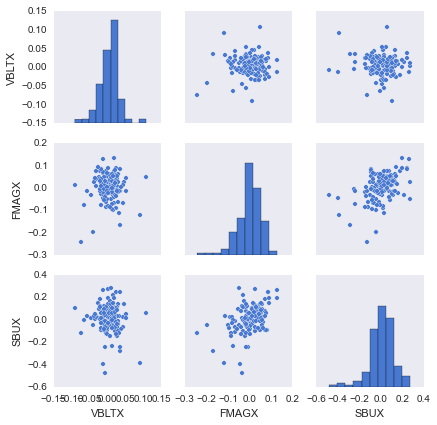

In [11]:
sns.pairplot(all_returns[1:],size=2)

#alternatively
#ax=pd.scatter_matrix(all_returns)

#compute covariance matrix
all_returns.cov()

,VBLTX,FMAGX,SBUX
VBLTX,1.000000,0.052925,-0.056573
FMAGX,0.052925,1.000000,0.448549
SBUX,-0.056573,0.448549,1.000000


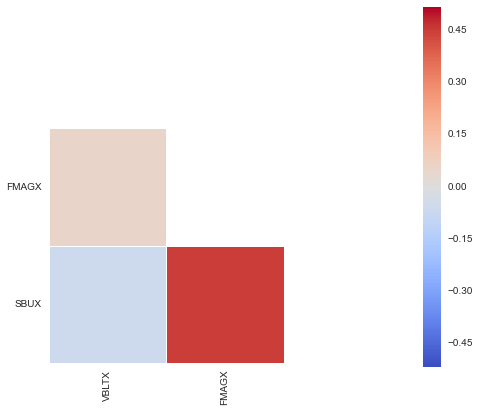

In [12]:
#plot correlations
sns.set(style="dark")
f, ax = plt.subplots(figsize=(7,7))
data=all_returns[1:]
sns.corrplot(data, annot=False, sig_stars=False,diag_names=False, ax=ax)
f.tight_layout()

#compute correlation matrix
all_returns.corr()
